In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statsmodels.api as sm
from script import *
from sarimax_script import *
import itertools
import arch

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
plt.rc('figure', figsize=(18.0, 6.0))

In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
df = load_building(4874, '2016-10-01 00:00:00', '2016-10-31 00:00:00')

In [5]:
df_weather_austin = load_weather('austin')

## GARCH model

In [6]:
def fit_garch(data):
    
    arch_model = arch.arch_model(data.Hourly_Usage, p=1, q=1)
    results = arch_model.fit(update_freq=5)
    
    return results

In [7]:
arch_model = arch.arch_model(df.Hourly_Usage, p=1, q=1)
results = arch_model.fit(update_freq=5)
print(results.summary)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 857.5600862542149
Iteration:     10,   Func. Count:     70,   Neg. LLF: 856.513665306034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 856.5133810330773
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:           Hourly_Usage   R-squared:                      -0.059
Mean Model:             Constant Mean   Adj. R-squared:                 -0.059
Vol Model:                      GARCH   Log-Likelihood:               -856.513
Distribution:                  Normal   AIC:                           1721.03
Method:            Maximum Likelihood   BIC:                           1739.35
                                        No. Observations:                  721
Date:                Thu, Sep 14 2017   Df Residuals:

In [10]:
def get_garch(data, model, building_id, final_date=None):
    
    start_train, end_train, start_test, end_test = find_dates(4874)
    
    arch_forecast = model.forecast(start=start_test)
    
    x = data.loc[start_train:end_test,'localhour']
    y_actual= data.loc[start_test:end_test, 'Hourly_Usage']
    y_predict = arch_forecast.variance
    
    return x, y_actual, y_predict
     

In [9]:
#function to plot GARCH forecast and mean squared error
def plot_garch(data, model, building_id, final_date=None):
    
    start_train, end_test = find_egauge_dates(4874)
    time_delta_1 = timedelta(days=1)
    time_delta_2 = timedelta(hours=1)
    end_train = end_test - time_delta_1
    start_test = end_train + time_delta_2
    start_plot = end_test - timedelta(days=4)
    start_train = str(start_train)
    end_train = str(end_train)
    start_test = str(start_test)
    end_test = str(end_test)
    start_plot = str(start_plot)
    
    plt.subplots(1,1,figsize=(20,6))
    arch_forecast = model.forecast(start=start_test)
    plt.plot(data.localhour, arch_forecast.variance)
    plt.plot(data.loc[start_plot:end_test, 'localhour'],data.loc[start_plot:end_test, 'Hourly_Usage'])
    plt.legend()
    
    return mean_squared_error(data.loc[start_test:,'Hourly_Usage'], arch_forecast.variance[-24:])

0.52353449980671851

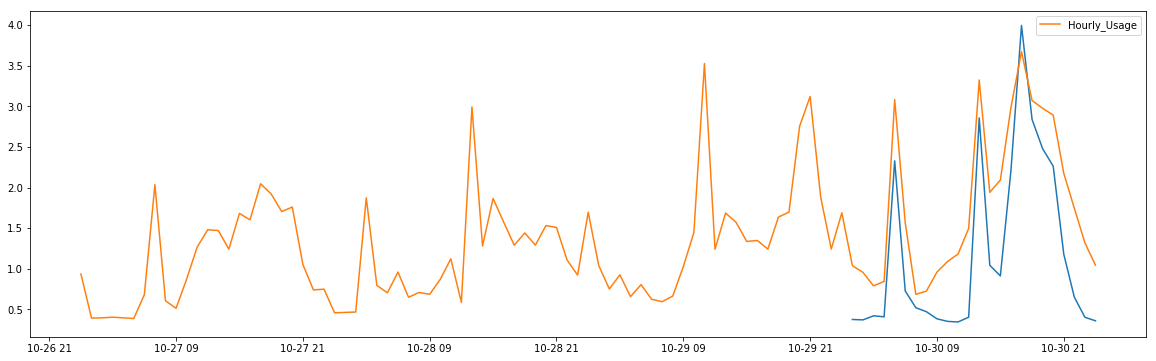

In [48]:
plot_garch(df, results, 4874)

## Facebook Prophet

In [9]:
from fbprophet import Prophet

In [26]:
df_prophet = pd.DataFrame(df.loc[start_train:end_train,'Hourly_Usage'])
df_prophet.rename(columns={'Hourly_Usage':'y'}, inplace=True)
df_prophet['ds'] = df_prophet.index
df_prophet['Temperature'] = df_weather_austin.loc[start_train:end_train, 'temperature']

#fill NaN temperatures
df_prophet.Temperature.fillna(np.mean(df_prophet['Temperature']), inplace=True)

In [27]:
prophet = Prophet()
prophet.add_regressor('Temperature')
prophet.fit(df_prophet)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [28]:
future = prophet.make_future_dataframe(periods=24, freq='H', include_history=False)
future.index = future.ds
future['Temperature'] = df_weather_austin.loc[start_train:end_test, 'temperature']
future.Temperature.fillna(np.mean(future['Temperature']),inplace=True)
future.head()

,ds,Temperature
ds,,
2016-10-30 01:00:00,2016-10-30 01:00:00,73.26
2016-10-30 02:00:00,2016-10-30 02:00:00,71.57
2016-10-30 03:00:00,2016-10-30 03:00:00,69.43
2016-10-30 04:00:00,2016-10-30 04:00:00,68.44
2016-10-30 05:00:00,2016-10-30 05:00:00,68.51


In [29]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
19,2016-10-30 20:00:00,1.977062,1.241169,2.819327
20,2016-10-30 21:00:00,1.772290,0.957797,2.518973
21,2016-10-30 22:00:00,1.575155,0.785305,2.361305
22,2016-10-30 23:00:00,1.372069,0.569083,2.173458
23,2016-10-31 00:00:00,1.142477,0.335432,1.926866


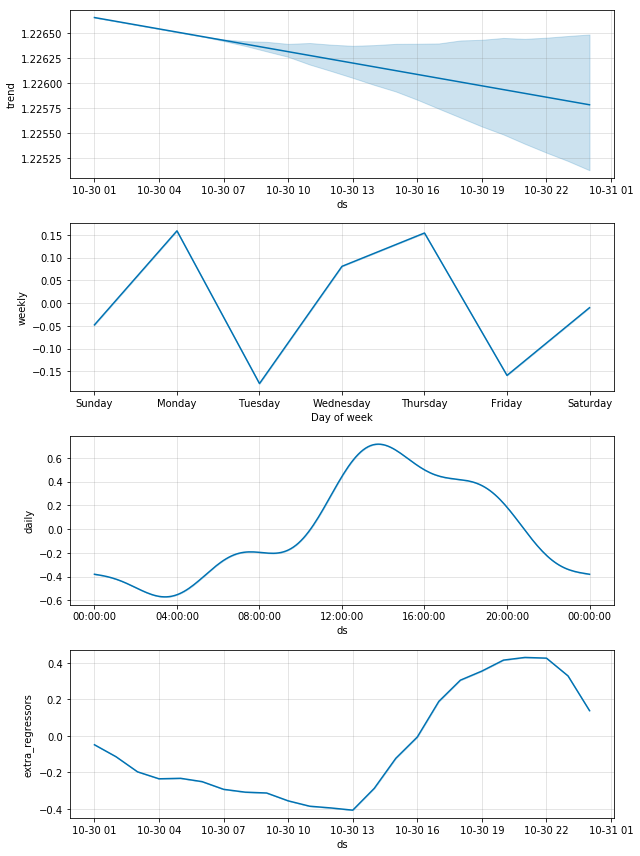

In [30]:
prophet.plot_components(forecast);

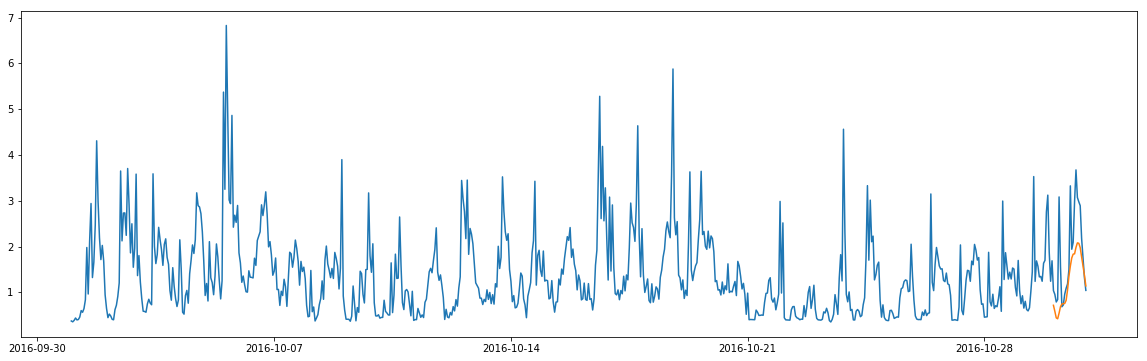

In [35]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df.index,df.Hourly_Usage)
plt.plot(forecast.ds[-24:], forecast.yhat[-24:])

In [37]:
mean_squared_error(df.Hourly_Usage[-24:],forecast.yhat[-24:])

0.75385715780216744